# Transformer un tableau

Une partie importante du travail est souvent de transformer les données

- Partir de données brutes
- Ajouter / recoder des éléments
- Produire des statistiques / visualisations finalisées 

## Charger les données

(avant recodage des modalités)

In [1]:
import pandas as pd

corpus = pd.read_csv("Data/europresse_HC_suisse_mod.csv")
corpus = corpus.drop("Unnamed: 0", axis=1).set_index("Date_reco")
corpus.head()

,Date,Titre,Journal,Contenu,Auteur,Journaux-reco,Freq_chloro
Date_reco,,,,,,,
2021-07-02,"International, vendredi 2 juillet 2021 860 m...","La stratégie covid brésilienne, un acharnemen...",Le Temps,7056 @fabiengoubet Avec Donald Trump en...,FABIEN GOUBET,Le Temps,4
2020-03-26,"Science, jeudi 26 mars 2020 2170 mots, p. 9",Chloroquine: une recherche controversée,Le Temps,6675 @fabiengoubet Voilà un peu plus d'...,FABIEN GOUBET,Le Temps,19
2020-06-16,"Économie, mardi 16 juin 2020 1192 mots, p. 15",[Transport aérien...],"Tribune de Genève, no. 5326",Transport aérien Qatar Airways va réduire ...,NaN,Tribune de Genève,20
2020-03-18,"Science, mercredi 18 mars 2020 1022 mots, p. 9",Une piste pour lutter contre le SARS-CoV-2,Le Temps,6668 (LE MONDE) La course aux traitemen...,SANDRINE CABUT,Le Temps,18
2020-03-20,"Point fort, vendredi 20 mars 2020 1558 mots,...",[Coronavirus...],"24 Heures (Suisse), no. 4306 Région, Lausanne",Coronavirus De la chloroquine contre le vi...,NaN,24 Heures,16


Si on fait toujours: `corpus.drop("Unnamed: 0", axis=1)`, on peut penser a enregistrer le CSV sans cette colonne.

## Remplacer des modalités

Quali quali

In [2]:
corpus["Journaux-reco"].value_counts()

Le Temps             110
Tribune de Genève     55
24 Heures             30
Le Matin              17
Bilan                 13
Autre                  7
La Liberté             5
Name: Journaux-reco, dtype: int64

Regrouper les quatre derniers ?

In [3]:
corpus["Journaux-reco"] = corpus["Journaux-reco"].replace(
    {"La Liberté": "Autre", "Bilan": "Autre"}
)
corpus["Journaux-reco"].value_counts()

Le Temps             110
Tribune de Genève     55
24 Heures             30
Autre                 25
Le Matin              17
Name: Journaux-reco, dtype: int64

Quanti Quali

In [7]:
pd.cut(corpus["Freq_chloro"], bins=[-0.01, 2, 5, 10, 100])

Date_reco
2021-07-02       (2.0, 5.0]
2020-03-26    (10.0, 100.0]
2020-06-16    (10.0, 100.0]
2020-03-18    (10.0, 100.0]
2020-03-20    (10.0, 100.0]
                  ...      
2000-05-17     (-0.01, 2.0]
2001-09-11     (-0.01, 2.0]
2005-01-03     (-0.01, 2.0]
NaN            (-0.01, 2.0]
2008-04-23     (-0.01, 2.0]
Name: Freq_chloro, Length: 237, dtype: category
Categories (4, interval[float64, right]): [(-0.01, 2.0] < (2.0, 5.0] < (5.0, 10.0] < (10.0, 100.0]]

In [8]:
corpus["cat_freq"] = pd.cut(
    corpus["Freq_chloro"],
    bins=[-0.01, 2, 5, 10, 100],
    labels=["0-2", "2-5", "5-10", ">10"],
)

Possible aussi les quantiles

In [9]:
pd.qcut(corpus["Freq_chloro"], 3).value_counts()

(-0.001, 1.0]    143
(2.0, 20.0]       50
(1.0, 2.0]        44
Name: Freq_chloro, dtype: int64

## Ajouter des modalités

Pour les chaines de caractères tout un ensemble de méthodes. Par ex : chloroquine dans le titre ?

In [10]:
corpus["Titre_min"] = corpus["Titre"].str.lower()

In [11]:
corpus["Titre_min"].str.contains("chloroquine").sum()

14

Possible aussi d'utiliser des conditions

In [12]:
corpus["Freq_sup_10"] = corpus["Freq_chloro"] > 10

In [13]:
corpus["Freq_sup_10"].value_counts()

False    232
True       5
Name: Freq_sup_10, dtype: int64

## Appliquer des traitements plus complexes

- méthode apply
- création de fonctions ad hoc

La méthode apply permet d'appliquer une fonction sur chaque cellule

In [14]:
corpus["nb_lettres"] = corpus["Contenu"].apply(len)

comment faire pour avoir le nombre de mots ?

- Définir une fonction pour une case
- L'appliquer

In [15]:
def nb_mots(x):
    return len(x.split(" "))

In [16]:
corpus["nb_mots"] = corpus["Contenu"].apply(nb_mots)

Et si maintenant on voulait la densité freq_chloroquine/nb_mots ? Il existe aussi apply sur un tableau (pas que sur une série) mais il faut indiquer dans quel sens parcourir le tableau

In [17]:
def calcul(ligne):
    return ligne["Freq_chloro"] / ligne["nb_mots"]


corpus["densite"] = corpus.apply(calcul, axis=1)

Faire l'histogramme

<AxesSubplot:>

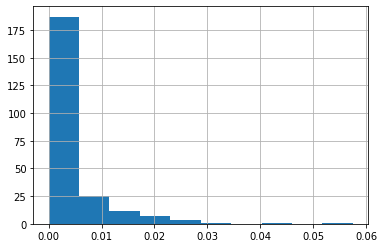

In [18]:
corpus["densite"].hist()

Filtrer les articles les plus "denses"

In [19]:
corpus[corpus["densite"] > 0.02]["Titre"]

Date_reco
2020-06-16                                     [États-Unis...] 
2021-11-03     "Le marché illégal s'adapte rapidement aux ru...
2020-04-18                                         MAIS ENCORE 
2020-06-04                                         MAIS ENCORE 
2020-03-24                                             EN BREF 
2020-07-11                                         MAIS ENCORE 
2020-06-24                 Covid-19, deux pays et un cauchemar 
2020-04-03             Didier Raoult, une visite au « druide » 
2020-05-20                  L'OMS face à l'ultimatum américain 
Name: Titre, dtype: object

## Exercice d'application

Créer une colonne avec les 10 mots les plus fréquents de plus de 5 lettres pour chaque article

## Aller plus loin (si temps)

- notion de fonction anonyme
- séries temporelles
- groupby
- tableaux croisés
- comprehension de liste